In [1]:
#FIX DATA GAPS
#CHOOSE TEST DATA WITHIN TRAIN DATA
#RERUN
# SUGGESTIONs FOR DATA: 1.LARGER BINS IN TIME (5 MINS 30 MINS 1 HOURS)
# 2. MEDIAN INSTEAD OF MEAN
# 3. LABELS: NOT ALL FRAMES ACTUALLY HAVE A FACE REGOGNIZED!!! CHECK THE 'SUCCESS' COLUMN (ALREADY THROWN OUT HERE)

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from FeatureRelated.feature_generator import Feature_generator
from LabelRelated.label_generator import Label_generator 
from FeatureRelated.feature_data_holder import FeatDataHolder
from LabelRelated.label_data_holder import LabelDataHolder
import warnings
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import time

In [4]:
#get datasets
feat_data=FeatDataHolder('/data2/users/stepeter/Preprocessing/processed_cb46fd46_4.h5')
label_data=LabelDataHolder('/home/emil/data/hdf_data/cb46fd46_8_imp_columns.hdf',feat_data.start,feat_data.end)

Warning. Start and end points for the given dataset is still manually set for patient c46fd46, day 4.


In [28]:
#edf_path, emo_path=get_paths(pat_name,sess)
featuregen=Feature_generator(feat_data)

In [40]:
#TODO don't show pass the mask here, do it somewhere else (Symbiosis class)
#TODO these numbers currently come from handpicking an interval of time that has continuous recordings
#They are considered in featuregen and have to be considered in the labels as well. DO THIS DIFFERENTLY THOUGH
lablegen=Label_generator(label_data,mask=featuregen.mask_bin)
#lablegen=Label_generator('/home/emil/data/hdf_data/cb46fd46_8_realtime.csv', wsize=1800,start=11,stop=43205)


In [49]:
#important configs
sliding=False
featuregen.wsize=100
lablegen.wsize=100
s_sample=0
e_sample=12500

In [50]:
#do simple tr/test linear regression
x=featuregen.generate_features(start=s_sample,end=e_sample,expl_variance=90,train=True,sliding_window=sliding)

Setting up PCA on current data range...


In [51]:
y,rat=lablegen.generate_labels(start=s_sample,end=e_sample, method='ratio', sliding_window=sliding)

[nan nan nan ... nan nan nan]


/home/emil/OpenMindv2/LabelRelated/label_generator.py:39: RuntimeWarning: Mean of empty slice
  non_nans_per_s = np.count_nonzero(~np.isnan(np.array(self.pred_bin, dtype='float')),axis = 1)
/home/emil/OpenMindv2/LabelRelated/label_generator.py:64: RuntimeWarning: Mean of empty slice
  if method =='ratio':


In [52]:
print(x.shape,y.shape)

(125, 100) (125,)


Text(0.5,1,'PC values w/ Happy ratio as Color')

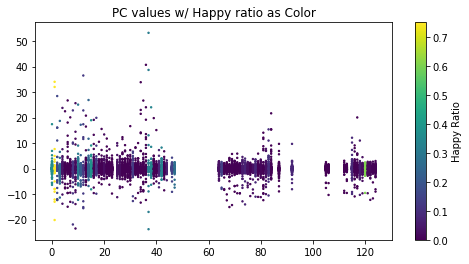

In [53]:
plt.figure(figsize=(8,4))
for i in range(x.shape[1]):
    plt.scatter(range(x.shape[0]), x[:,i], c=y, s=2)
cbar=plt.colorbar()
cbar.set_label('Happy Ratio')
plt.title('PC values w/ Happy ratio as Color')

Text(0,0.5,'Happiness ratio (Mean)')

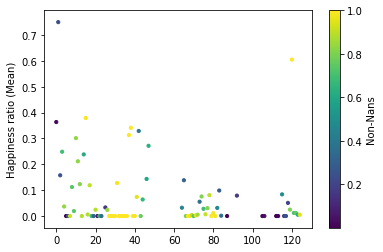

In [61]:
plt.scatter(range(len(y)),y,c=rat,s=10)
cbar=plt.colorbar()
cbar.set_label('Non-Nans')
plt.ylabel('Happiness ratio (Mean)')

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Window')
ax1.set_ylabel('PC Score (Median)', color=color)
plt.plot(range(x.shape[0]), np.median(x, axis=1), color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Happy Score (Median)', color=color)  # we already handled the x-label with ax1
ax2.plot(y[0], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
print(x.shape)
y[0].shape

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(np.row_stack((x.T,y*300)))
cbar=plt.colorbar()
cbar.set_label('Score/Happiness')
plt.xlabel('Window')
plt.ylabel('PC No./Happiness')
plt.title('Visualization of Happiness and PC scores over time')


In [ ]:
#which Bins/Electrodes contribute the most???
print(featuregen.data.shape, featuregen.curr_data.shape)
ttest=np.abs(featuregen.pca.transform(np.eye(featuregen.curr_data.shape[1])))

In [ ]:
ttest.shape

In [ ]:
for pl in range((ttest.shape[1])):
    plt.scatter(ttest.shape[0]*[pl],range(ttest.shape[0]), c=ttest[:,pl])
cbar=plt.colorbar()
cbar.set_label('test')

In [ ]:
ttest.shape

In [ ]:
#how much did each bin contribute?
ttest_sum=ttest.sum(axis=1)
ttest_shaped=ttest_sum.reshape(featuregen.data.shape[0],-1)
cont_bins=ttest_shaped.sum(axis=0)
cont_elecs=ttest_shaped.sum(axis=1)
plt.bar(np.arange(len(cont_bins)),cont_bins)
plt.xticks(np.arange(len(cont_bins)),np.exp2(np.arange(8)).astype('int'))
plt.show()
plt.plot(cont_elecs)

In [ ]:
# ##all for debugging purposes
# # df=pd.read_csv('/home/emil/data/hdf_data/cb46fd46_8_realtime.csv',error_bad_lines=False, low_memory=False,parse_dates=['realtime'])

# # df['realtime'][:]

# # som_ob=df['realtime'][1:]-df['realtime'][:-1]
# # som_ob[0]

# # tot=0
# # # for i in range(1,(df.shape[0])):
# # #     if (df.loc[i][-1]-df.loc[i-1][-1]).seconds >0:
# # #         tot=(df.loc[i][-1]-df.loc[i-1][-1]).seconds
# # #         sec= tot/1000
# # #         print('seconds passed since last frame: %d, which was on frame %d' % (tot, i), 'which is at', df.loc[i][-1])
# # tot=0
# # for i in range(1,3481):
# #     if df.loc[i][0]-df.loc[i-1][0] >1:
# #         print('hoppla')
# # tot

# # df['Happy_predicted'].value_counts()

# import h5py
# scrrr=h5py.File('/data2/users/stepeter/Preprocessing/processed_cb46fd46_4.h5')

# scrrr['dataset'].shape[1]/500

In [ ]:
print(x.shape)
print(y.shape)

In [ ]:
ran=6
for i in range(ran):
    plt.plot(featuregen.curr_data[:,i])
plt.title(' First %d features in Featurevector over time' % ran)
plt.show()
plt.plot(y)
plt.xlabel('Time in increments of 30s')
plt.ylabel('Happiness score')
plt.show()

In [ ]:
x_ev=featuregen.generate_features(start=10000,end=12000,train=False,sliding_window=sliding)

y_ev, y_ev_rat=lablegen.generate_labels(start=10000,end=12000,sliding_window=sliding, mask=featuregen.mask_bin)

In [ ]:
# print(y.shape)
# print(y_ev.shape)
# print(x.shape)
# print(x_ev.shape)
# #print(y.shape)
# lel=(featuregen.mask_bin[:30000].reshape(featuregen.wsize,-1))
# print(lel.shape)
# lel=np.any(lel,axis=0)
# np.unique(lel,return_counts=True)

In [ ]:
#plot different things

featuregen.vis_pc()

#featuregen.vis_raw_data(start=16000,stop=20000)

featuregen.curr_data.shape

#Plotting the actual features over time. Here, plot the first five features.
ran=45
for i in range(ran):
    plt.plot(featuregen.curr_data[:,i])
plt.title(' First %d features in Featurevector over time' % ran)
plt.show()
plt.plot(y_ev)
plt.xlabel('Time in increments of 30s')
plt.ylabel('Happiness score')
plt.show()

In [ ]:
x=x[~np.isnan(y)]
y=y[~np.isnan(y)]
x_ev=x_ev[~np.isnan(y_ev)]
y_ev=y_ev[~np.isnan(y_ev)]

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn import linear_model

In [ ]:
ols=linear_model.LinearRegression()
ridge=RidgeCV(alphas=np.array([1000000000,100,10000,1000,10,1,.1,]),store_cv_values=True)
#ridge=linear_model.Ridge(alpha=10000)
ols.fit(x,y)
ridge.fit(x,y)

In [ ]:
plt.plot(y)

In [ ]:
plt.plot(y_ev)

In [ ]:
y_pred_l=ols.predict(x_ev)
y_pred_ridge=ridge.predict(x_ev)

plt.plot(y_pred_l,label='LR Pred')
plt.plot(y_pred_ridge,label='RR Pred')
plt.title('Linear Regression, Ridge regression w/ alpha=%d' % ridge.alpha_)
plt.plot(y_ev,label='Test Data')
plt.legend()
plt.show()

y_tr_pred_l=ols.predict(x)
y_tr_pred_ridge=ridge.predict(x)

plt.plot(y_tr_pred_l,label='LR Pred')
plt.plot(y_tr_pred_ridge,label= 'RR Pred')
plt.title('Linear Regression, Ridge regression w/ alpha=%d' % ridge.alpha_)
plt.plot(y, label='Train Data')
plt.legend()
plt.show()

In [ ]:
print(ridge.cv_values_.shape)
plt.plot(ridge.cv_values_[:,3])
plt.title('Cross Validation MSE, for alpha=%3f'% ridge.alphas[3])
plt.ylabel('MSE')
plt.xlabel('Iteration')

In [ ]:
#try Kernel Ridge
kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), cv=5,
                  param_grid={"alpha": [1e2,1e4,1e0, 0.1, 1e-2],
                              "gamma": np.logspace(-4, 4, 25)},scoring='neg_mean_squared_error',n_jobs=-1)


kr.fit(x,y)


In [ ]:
al, ga=kr.best_params_.values()
print(al,ga)

In [ ]:
y_kr_pred=kr.predict(x_ev)
plt.plot(y_ev, label='Test')
plt.plot(y_kr_pred,label='Prediction')
plt.xlabel('time (in 30s window - increments)')
plt.ylabel('Happiness score')
plt.title('Ridge Reg w/ RBF Kernel, gamma=%.4f, alpha=%1.2f' %(ga,al))
plt.legend()
plt.show()
y_kr_pred_tr=kr.predict(x)
plt.plot(y, label='Train')
plt.plot(y_kr_pred_tr,label='Prediction')
plt.xlabel('time (in 30s window - increments)')
plt.ylabel('Happiness score')
plt.legend()

In [ ]:
kr.best_estimator_

In [ ]:
kr.cv_results_

In [ ]:
#try poly Ridge
pol = GridSearchCV(KernelRidge(kernel='poly', gamma=0.1), cv=10,
                  param_grid={"alpha": [1e5,1e6,1e3,1e2,1e0,1e-1,1e-2],
                              "degree": np.random.choice(np.arange(1, 60),5, replace=False)},scoring='neg_mean_squared_error',n_jobs=-1)


pol.fit(x,y)

In [ ]:
al, de=pol.best_params_.values()
print(al,de)

In [ ]:
print('Best params',pol.best_params_)
y_pol_pred=pol.predict(x_ev)
plt.plot(y_ev[:-3], label='Test')
plt.plot(y_pol_pred[:-3],label='Prediction')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Happiness')
plt.title('Poly Kernel, d=%d, lambda=%1f' %(de,al))
plt.show()
y_pol_pred_tr=pol.predict(x)
plt.plot(y, label='Train')
plt.plot(y_pol_pred_tr,label='Prediction')
plt.legend()

In [ ]:
ranf = GridSearchCV(RandomForestRegressor(), cv=5,
                  param_grid={"max_depth": np.random.choice(np.arange(10,100),20,replace=False),
                              "n_estimators": np.random.choice(np.arange(10,100),20,replace=False)},scoring='neg_mean_squared_error',n_jobs=-1)
ranf.fit(x,y)

In [ ]:
print('Best params',ranf.best_params_)
y_ranf_pred=ranf.predict(x_ev)
plt.plot(y_ev, label='Test')
plt.plot(y_ranf_pred,label='Prediction')
plt.legend()
plt.show()
y_ranf_pred_tr=ranf.predict(x)
plt.plot(y[:200], label='Train')
plt.plot(y_ranf_pred_tr[:200],label='Prediction')
plt.legend()

In [ ]:
plt.plot(np.dot(featuregen.curr_data,featuregen.pca.components_.T))
plt.xlabel('Time (in w_size)')
plt.ylabel('PC Value')
plt.title('First %d principal components' % featuregen.pca.n_components)
plt.show()


In [ ]:
plt.plot(x_tr)


In [ ]:
reconstr=np.dot(x_tr ,featuregen.pca.components_)

In [ ]:
fig = plt.figure(figsize=(15,15))
plt.imshow(reconstr,cmap='plasma')

In [ ]:
#fig = plt.figure(figsize=(15,15))
plt.imshow(x_tr[:250].T,vmin=np.min(x_tr),vmax=np.max(x_tr))
print(np.mean(x_tr))
plt.show()
plt.plot(y_tr)
chans=np.arange(4,20)
data=featuregen.data[chans,0:30000]
for p in range(0,len(chans)-1):
    plt.plot(data[p])
plt.xlabel('No. Samples (500Hz sample freq.)')
plt.ylabel('mV')
plt.show()

In [ ]:
featuregen.curr_data.shape

In [ ]:
rem=featuregen.curr_data[:].T
plt.imshow(rem,cmap='plasma',aspect='auto')
plt.xlabel('Time in 30s increments')
plt.gca().invert_yaxis()
plt.ylabel('Chans x Bins')


In [ ]:
np.unique(featuregen.bad_idx,return_counts=True)